In [1]:
import geopandas as gpd

# import the GeoPackage with the traffic change calculations from the "Analysis" Notebook
updated_data = gpd.read_file("docs/traffic_change_analysis.gpkg", layer="traffic_pct_change")

# Confirm the new fields are there
print(updated_data.columns)


Index(['COGID', 'RTE', 'LOCAT', 'PRE_ART_2_YEAR_MEAN', 'POST_ART_2_YEAR_MEAN',
       'PRE_ART_5_YEAR_MEAN', 'POST_ART_5_YEAR_MEAN', 'PCT_CHANGE_2_YR',
       'PCT_CHANGE_5_YR', 'PCT_2_YR_CLEAN', 'PCT_5_YR_CLEAN', 'IS_ART',
       'IS_ART_ADJ', 'ABS_CHANGE_2_YR', 'ABS_CHANGE_5_YR', 'ABS_2_YR_CLEAN',
       'ABS_5_YR_CLEAN', 'geometry'],
      dtype='object')


In [2]:
updated_data.shape

(3048, 18)

In [5]:
census_data = gpd.read_file('../census_xwalk/Data/pop_growth.gpkg')

census_data.columns

Index(['GEOID', 'pop_12', 'pop_22', 'pop_growth', 'geometry'], dtype='object')

In [6]:
census_data.head()

,GEOID,pop_12,pop_22,pop_growth,geometry
0,35001003400,4243.0,4179.0,-64.0,"POLYGON ((-106.62774 35.10917, -106.62573 35.1..."
1,35001000712,4127.0,4052.0,-75.0,"POLYGON ((-106.50642 35.07402, -106.50622 35.0..."
2,35001000206,3059.0,3363.0,304.0,"POLYGON ((-106.58643 35.12329, -106.58376 35.1..."
3,35001004749,4583.0,4746.0,163.0,"POLYGON ((-106.71464 35.11297, -106.70829 35.1..."
4,35001000126,2691.0,2299.0,-392.0,"POLYGON ((-106.51544 35.10146, -106.50642 35.1..."


In [8]:
census_data[['pop_12', 'pop_22', 'pop_growth']].head()

,pop_12,pop_22,pop_growth
0,4243.0,4179.0,-64.0
1,4127.0,4052.0,-75.0
2,3059.0,3363.0,304.0
3,4583.0,4746.0,163.0
4,2691.0,2299.0,-392.0


In [12]:
# Drop rows with missing values
filtered_2yr = updated_data.dropna(subset=['ABS_2_YR_CLEAN', 'PCT_2_YR_CLEAN'])
filtered_5yr = updated_data.dropna(subset=['ABS_5_YR_CLEAN', 'PCT_5_YR_CLEAN'])

art_study_area = updated_data[(updated_data['IS_ART'] == 1) | (updated_data['IS_ART_ADJ'] == 1)]
filtered_art_2yr = art_study_area.dropna(subset=['ABS_2_YR_CLEAN', 'PCT_2_YR_CLEAN'])

census_data = census_data.dropna(subset=['pop_12', 'pop_22', 'pop_growth'])  # Optional

# Then use the filtered versions in your add_traffic_layer calls


In [13]:
filtered_2yr.head()

,COGID,RTE,LOCAT,PRE_ART_2_YEAR_MEAN,POST_ART_2_YEAR_MEAN,PRE_ART_5_YEAR_MEAN,POST_ART_5_YEAR_MEAN,PCT_CHANGE_2_YR,PCT_CHANGE_5_YR,PCT_2_YR_CLEAN,PCT_5_YR_CLEAN,IS_ART,IS_ART_ADJ,ABS_CHANGE_2_YR,ABS_CHANGE_5_YR,ABS_2_YR_CLEAN,ABS_5_YR_CLEAN,geometry
0,10003,UNSER BLVD.,NORTH OF NORTHERN - SOUTH OF 15TH AVE.,23542.0,24358.0,23399.4,22251.0,3.466146,-4.907818,3.47,-4.91,0,0,816.0,-1148.4,816.0,-1148.0,"MULTILINESTRING ((-106.69681 35.27459, -106.69..."
1,10004,N.M. 528,NORTH OF CORRALES RD. (NM 448) - .118 MILES N...,28275.5,27846.0,24567.4,25606.2,-1.518983,4.228368,-1.52,4.23,0,0,-429.5,1038.8,-430.0,1039.0,"MULTILINESTRING ((-106.6174 35.27542, -106.615..."
2,10005,GRANDE VISTA,NORTH OF CORRALES RD. - SOUTH OF SANDIA VISTA,1960.0,2205.0,2195.8,2062.0,12.500000,-6.093451,12.50,-6.09,0,0,245.0,-133.8,245.0,-134.0,"MULTILINESTRING ((-106.6135 35.2736, -106.6131..."
3,10006,GRANDE VISTA,NORTH OF SANDIA VISTA - S.E. OF N.M. 528,966.5,1272.0,918.0,889.4,31.608898,-3.115468,31.61,-3.12,0,0,305.5,-28.6,306.0,-29.0,"MULTILINESTRING ((-106.61107 35.27551, -106.61..."
4,10007,SANDIA VISTA,S.E. OF GRANDE VISTA - EAST OF N.M. 528,913.5,1577.5,838.0,1475.0,72.687466,76.014320,72.69,76.01,0,0,664.0,637.0,664.0,637.0,"MULTILINESTRING ((-106.61107 35.27551, -106.61..."


In [20]:
import folium
from folium import FeatureGroup
from branca.colormap import LinearColormap
import geopandas as gpd
from branca.colormap import StepColormap

# === Load your data ===
updated_data = gpd.read_file("docs/traffic_change_analysis.gpkg", layer="traffic_pct_change") # Traffic Data
census_data = gpd.read_file('../census_xwalk/Data/pop_growth.gpkg') # Read in Census Data

# === Create the combined ART study area layer ===
art_study_area = updated_data[(updated_data['IS_ART'] == 1) | (updated_data['IS_ART_ADJ'] == 1)]

# === Define color ramp for absolute change ===
abs_colormap = LinearColormap(
    colors=['#d73027', '#fc8d59', '#cccccc', '#91cf60', '#1a9850'],
    vmin=-3000, vmax=3000,
    caption='Absolute Change in Daily Traffic Volume'
)

# === Define traffic layer adding function ===
def add_traffic_layer(gdf, abs_col, pct_col, label, show=True):
    group = FeatureGroup(name=label, show=show)
    for _, row in gdf.iterrows():
        abs_change = int(row[abs_col])
        pct_change = round(row[pct_col], 1)
        tooltip_html = (
            f"<b>Route:</b> {row['RTE']}<br>"
            f"<b>Location:</b> {row['LOCAT']}<br>"
            f"<b>Abs Change:</b> {abs_change}<br>"
            f"<b>% Change:</b> {pct_change}%"
        )
        folium.GeoJson(
            row['geometry'],
            style_function=lambda feature, value=abs_change: {
                'color': abs_colormap(value),
                'weight': 3,
                'opacity': 0.8
            },
            tooltip=folium.Tooltip(tooltip_html, sticky=True)
        ).add_to(group)
    group.add_to(m)

# === Define census layer adding function ===
def add_census_layer(gdf, growth_col, label):
    group = folium.FeatureGroup(name=label, show=False)
    max_abs = max(abs(census_data['pop_growth'].min()), abs(census_data['pop_growth'].max()))
    
    vmin = census_data['pop_growth'].min()
    vmax = census_data['pop_growth'].max()
    
    pop_colormap = StepColormap(
        colors=['#b2182b', '#ef8a62', '#fddbc7', '#d1e5f0', '#67a9cf', '#2166ac'],
        index=[-1237, -500, -100, 100, 500, 6898],
        vmin=vmin,
        vmax=vmax,
        caption='Population Change (2012–2022)'
    )


    
#     pop_colormap = LinearColormap(
#         colors=['darkred', 'white', 'darkblue'],
#         vmin=-max_abs, vmax=max_abs,
#         caption='Population Change (2012–2022)'
# )
    
    for _, row in gdf.iterrows():
        popup_html = (
            f"<b>Population 2012:</b> {int(row['pop_12'])}<br>"
            f"<b>Population 2022:</b> {int(row['pop_22'])}<br>"
            f"<b>Change:</b> {int(row['pop_growth'])}"
        )
        folium.GeoJson(
            row['geometry'],
            style_function=lambda feature, growth=row[growth_col]: {
                'fillColor': pop_colormap(growth),
                'color': 'black',
                'weight': 0.5,
                'fillOpacity': 0.6
            },
            tooltip=folium.Tooltip(popup_html, sticky=True)
        ).add_to(group)
    group.add_to(m)
    pop_colormap.caption = label
    #pop_colormap.add_to(m) #taking away Label for now

# === Initialize the map ===
m = folium.Map(location=[35.0844, -106.6504], zoom_start=12, tiles='CartoDB positron')

# === Add layers using cleaned data ===
add_traffic_layer(filtered_2yr, 'ABS_2_YR_CLEAN', 'PCT_2_YR_CLEAN', '2-Year Absolute Change (All)', show=True)
add_traffic_layer(filtered_5yr, 'ABS_5_YR_CLEAN', 'PCT_5_YR_CLEAN', '5-Year Absolute Change (All)', show=False)
add_traffic_layer(filtered_art_2yr, 'ABS_2_YR_CLEAN', 'PCT_2_YR_CLEAN', '2-Year Absolute Change (ART Study Area)', show=False)
add_census_layer(census_data, 'pop_growth', 'Population Change (2012–2022)')


# === Add legend and layer control ===
abs_colormap.add_to(m)
folium.LayerControl().add_to(m)

# === Save the map ===
m.save('ART_clean_map.html')


<Axes: >

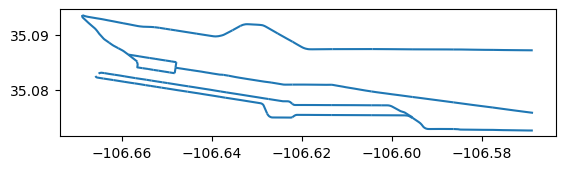

In [2]:
# Need to make a new map that only focuses on the ART East Study Area The whole region
# Is unnecessary
import geopandas as gpd

east_study_area = gpd.read_file("docs/ART_EAST_STUDY_AREA.gpkg")
east_study_area.plot()

In [3]:
east_study_area.columns

Index(['COGID', 'RTE', 'LOCAT', 'PRE_ART_2_YEAR_MEAN', 'POST_ART_2_YEAR_MEAN',
       'PRE_ART_5_YEAR_MEAN', 'POST_ART_5_YEAR_MEAN', 'PCT_CHANGE_2_YR',
       'PCT_CHANGE_5_YR', 'PCT_2_YR_CLEAN', 'PCT_5_YR_CLEAN', 'IS_ART',
       'IS_ART_ADJ', 'ABS_CHANGE_2_YR', 'ABS_CHANGE_5_YR', 'ABS_2_YR_CLEAN',
       'ABS_5_YR_CLEAN', 'MILES', 'IS_COAL', 'IS_LEAD', 'IS_ZUNI', 'IS_LOMAS',
       'VMT_CHANGE_2_YR', 'VMT_CHANGE_5_YR', 'PRE_VMT_2_YR', 'POST_VMT_2_YR',
       'VMT_PCT_CHANGE_2_YR', 'PRE_VMT_5_YR', 'POST_VMT_5_YR',
       'VMT_PCT_CHANGE_5_YR', 'geometry'],
      dtype='object')

In [10]:
# I don't like this one becuase the red to green has too much grey in the middle
# Too many links look grey and match the basemap - let's try a simple red vs green

# #Let's get the new folium map up with Chatgpt's help
# import folium
# from folium import FeatureGroup
# from branca.colormap import LinearColormap
# import geopandas as gpd
# import pandas as pd

# # === Load data ===
# east_study_area = gpd.read_file("docs/ART_EAST_STUDY_AREA.gpkg")

# # === Calculate bounds for centering the map ===
# bounds = east_study_area.total_bounds  # [minx, miny, maxx, maxy]
# center_lat = (bounds[1] + bounds[3]) / 2
# center_lon = (bounds[0] + bounds[2]) / 2

# # === Define tighter color ramp for better contrast ===
# vmt_colormap = LinearColormap(
#     colors=['#d73027', '#fc8d59', '#cccccc', '#91cf60', '#1a9850'],
#     vmin=-4000, vmax=4000,
#     caption='Absolute Change in Daily VMT'
# )

# # === Define function to add VMT layers ===
# def add_vmt_layer(gdf, abs_col, pct_col, label, show=True):
#     group = FeatureGroup(name=label, show=show)
#     for _, row in gdf.iterrows():
#         abs_change = int(row[abs_col]) if pd.notna(row[abs_col]) else 0
#         pct_change = round(row[pct_col], 1) if pd.notna(row[pct_col]) else 0
#         tooltip_html = (
#             f"<b>Route:</b> {row['RTE']}<br>"
#             f"<b>Location:</b> {row['LOCAT']}<br>"
#             f"<b>Abs VMT Change:</b> {abs_change}<br>"
#             f"<b>% VMT Change:</b> {pct_change}%"
#         )
#         folium.GeoJson(
#             row['geometry'],
#             style_function=lambda feature, value=abs_change: {
#                 'color': vmt_colormap(value),
#                 'weight': 3,
#                 'opacity': 0.8
#             },
#             tooltip=folium.Tooltip(tooltip_html, sticky=True)
#         ).add_to(group)
#     group.add_to(m)

# # === Initialize map with better centering ===
# m = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles='CartoDB positron')

# # === Add VMT change layers ===
# add_vmt_layer(east_study_area, 'VMT_CHANGE_2_YR', 'VMT_PCT_CHANGE_2_YR', '2-Year VMT Change', show=True)
# add_vmt_layer(east_study_area, 'VMT_CHANGE_5_YR', 'VMT_PCT_CHANGE_5_YR', '5-Year VMT Change', show=False)

# # === Add legend and layer control ===
# vmt_colormap.add_to(m)
# folium.LayerControl().add_to(m)

# # === Save to HTML file ===
# m.save("ART_East_VMT_Map.html")



In [9]:
# going to try again with line weights

import folium
from folium import FeatureGroup
import geopandas as gpd
import pandas as pd

# === Load data ===
east_study_area = gpd.read_file("docs/ART_EAST_STUDY_AREA.gpkg")

# === Calculate bounds to auto-center the map ===
bounds = east_study_area.total_bounds  # [minx, miny, maxx, maxy]

# === Define style function based on VMT change ===

def style_function_vmt(row, abs_col):
    change = row[abs_col]
    
    # Color: green for increase, red for decrease
    color = '#1a9850' if change > 0 else '#d73027'
    
    # Graduated width based on magnitude
    abs_change = abs(change)
    if abs_change > 3000:
        weight = 6
    elif abs_change > 2000:
        weight = 4.5
    elif abs_change > 1000:
        weight = 3
    elif abs_change > 500:
        weight = 2
    else:
        weight = 1.5

    return {
        'color': color,
        'weight': weight,
        'opacity': 0.8
    }

# === Define layer-adding function ===
def add_vmt_layer(gdf, abs_col, pct_col, label, show=True):
    group = FeatureGroup(name=label, show=show)
    
    for _, row in gdf.iterrows():
        # Handle tooltip
        abs_change = int(row[abs_col]) if pd.notna(row[abs_col]) else 0
        pct_change = round(row[pct_col], 1) if pd.notna(row[pct_col]) else 0
        tooltip_html = (
            f"<b>Route:</b> {row['RTE']}<br>"
            f"<b>Location:</b> {row['LOCAT']}<br>"
            f"<b>Abs VMT Change:</b> {abs_change}<br>"
            f"<b>% VMT Change:</b> {pct_change}%"
        )
        
        # Create a single-feature GeoDataFrame to preserve attributes
        single_gdf = gpd.GeoDataFrame([row], crs=gdf.crs)

        folium.GeoJson(
            single_gdf,
            style_function=lambda feature: style_function_vmt(feature['properties'], abs_col),
            tooltip=folium.Tooltip(tooltip_html, sticky=True)
        ).add_to(group)

    group.add_to(m)


# === Initialize map using "Zoom to Full Extent" logic ===
m = folium.Map(tiles='CartoDB positron')
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# === Add layer ===
#Let's add the 5 year as well but not show it automatically - you can toggle it on
add_vmt_layer(east_study_area, 'VMT_CHANGE_2_YR', 'VMT_PCT_CHANGE_2_YR', '2-Year VMT Change', show=True)
add_vmt_layer(east_study_area, 'VMT_CHANGE_5_YR', 'VMT_PCT_CHANGE_5_YR', '5-Year VMT Change', show=False)


# === Add layer control and save ===
folium.LayerControl().add_to(m)

#m.get_root().html.add_child(folium.Element(legend_html))

m.save("ART_East_VMT_Graduated.html")


In [10]:
# going to try again with line weights

import folium
from folium import FeatureGroup
import geopandas as gpd
import pandas as pd

# === Load data ===
east_study_area = gpd.read_file("docs/ART_EAST_STUDY_AREA.gpkg")

# === Calculate bounds to auto-center the map ===
bounds = east_study_area.total_bounds  # [minx, miny, maxx, maxy]

# === Define style function based on VMT change ===

def style_function_vmt(row, abs_col):
    change = row[abs_col]
    
    # Color: green for increase, red for decrease
    color = '#1a9850' if change > 0 else '#d73027'
    
    # Graduated width based on magnitude
    abs_change = abs(change)
    if abs_change > 3000:
        weight = 6
    elif abs_change > 2000:
        weight = 4.5
    elif abs_change > 1000:
        weight = 3
    elif abs_change > 500:
        weight = 2
    else:
        weight = 1.5

    return {
        'color': color,
        'weight': weight,
        'opacity': 0.8
    }

# === Define layer-adding function ===
def add_vmt_layer(gdf, abs_col, pct_col, label, show=True):
    group = FeatureGroup(name=label, show=show)
    
    for _, row in gdf.iterrows():
        # Handle tooltip
        abs_change = int(row[abs_col]) if pd.notna(row[abs_col]) else 0
        pct_change = round(row[pct_col], 1) if pd.notna(row[pct_col]) else 0
        tooltip_html = (
            f"<b>Route:</b> {row['RTE']}<br>"
            f"<b>Location:</b> {row['LOCAT']}<br>"
            f"<b>Abs VMT Change:</b> {abs_change}<br>"
            f"<b>% VMT Change:</b> {pct_change}%"
        )
        
        # Create a single-feature GeoDataFrame to preserve attributes
        single_gdf = gpd.GeoDataFrame([row], crs=gdf.crs)

        folium.GeoJson(
            single_gdf,
            style_function=lambda feature: style_function_vmt(feature['properties'], abs_col),
            tooltip=folium.Tooltip(tooltip_html, sticky=True)
        ).add_to(group)

    group.add_to(m)


# === Initialize map using "Zoom to Full Extent" logic ===
m = folium.Map(tiles='CartoDB positron')
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# === Add layer ===
#Let's add the 5 year as well but not show it automatically - you can toggle it on
add_vmt_layer(east_study_area, 'VMT_CHANGE_2_YR', 'VMT_PCT_CHANGE_2_YR', '2-Year VMT Change', show=True)
add_vmt_layer(east_study_area, 'VMT_CHANGE_5_YR', 'VMT_PCT_CHANGE_5_YR', '5-Year VMT Change', show=False)



# === Add layer control and save ===
folium.LayerControl().add_to(m)
legend_html = """
<div style="
    position: fixed; 
    bottom: 20px; left: 20px; width: 240px; 
    background-color: white;
    border:2px solid grey; z-index:9999;
    font-size:14px;
    padding: 10px;
    box-shadow: 2px 2px 5px rgba(0,0,0,0.3);
">
<b>VMT Change Legend</b><br>
<div style="line-height: 1.6; margin-top: 8px;">
  <svg height="6" width="60"><line x1="0" y1="3" x2="60" y2="3" style="stroke:#333;stroke-width:6" /></svg> ≥ 3000 VMT<br>
  <svg height="6" width="60"><line x1="0" y1="3" x2="60" y2="3" style="stroke:#333;stroke-width:4.5" /></svg> 2001–3000 VMT<br>
  <svg height="6" width="60"><line x1="0" y1="3" x2="60" y2="3" style="stroke:#333;stroke-width:3" /></svg> 1001–2000 VMT<br>
  <svg height="6" width="60"><line x1="0" y1="3" x2="60" y2="3" style="stroke:#333;stroke-width:2" /></svg> 501–1000 VMT<br>
  <svg height="6" width="60"><line x1="0" y1="3" x2="60" y2="3" style="stroke:#333;stroke-width:1.5" /></svg> ≤ 500 VMT<br>
</div>
<div style="margin-top: 10px;">
  <span style="display:inline-block;width:14px;height:14px;background:#1a9850;border-radius:2px;margin-right:5px;"></span> Increase<br>
  <span style="display:inline-block;width:14px;height:14px;background:#d73027;border-radius:2px;margin-right:5px;"></span> Decrease
</div>
</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))

m.save("ART_East_VMT_Graduated_Legend.html")
